<a href="https://colab.research.google.com/github/soraochi1626-cmd/economics-study/blob/main/econometrics/simple_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install py4macro
!pip install wooldridge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.7 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import py4macro    # 属性を調べるsee()関数が含まれる
import statsmodels.formula.api as smf  # 回帰分析のパッケージ
import wooldridge  # wooldridgeのデータ・パッケージ

from scipy.stats import norm    # 正規分布関数
from numba import njit  # シミュレーションの計算を高速化する

# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

#説明
説明変数が一つの単回帰(Simple Regression)を考える。<br>

$$y_i = \beta_0 + \beta_1x_i + u_i$$<br>
・$y_i$：非説明変数(従属変数)<br>
・$x_i$：説明変数(独立変数)<br>
・$u_i$：誤差項<br>
・$i = 1, 2, …, n$：観測値のインデックス<br>
・$\beta_0$：定数項(観測不可能なため推定する)<br>
・$\beta_1$：スロープ係数(観測不可能なため推定する
)




**最小二乗推定法**

$$ \sum_{i=1}^{n} (y_i - \beta_0 - \beta_1{x_i})^2 $$

を最小化する$\beta_0$と$\beta_1$を選択すると以下を得る：

$$\hat{\beta_0} = \bar{y} - \hat{\beta_1}\bar{x}$$
$$\hat{\beta_1} = \frac{Cov(x, y)}{Var(x)}$$

・^(ハット)がある変数($\hat{\beta_0}$と$\hat{\beta_1}$)を**OSL推定量**と呼ぶ<br>
・-(バー)がある変数($\bar{y}$)は平均値<br>
・$Cov(x, y)$は$x$と$y$の共分散<br>
・$Var(x)$は$x$の分散<br>
・$x$のように添字$i$を省いた場合は$x_1$から$x_n$までのすべての観測地という意味($y$も同じ)<br>

また以下を定義する

・予測値$\hat{y_i}$<br>$$\hat{y_i} = \hat{\beta_0} + \hat{\beta_1}{x_i}$$
・残差$\hat{u_i}$<br>$$\hat{u_i} = y_i - \hat{y_i}$$



###データ
Wooldridge (2019)で使われるデータセットは全てwooldridgeのパッケージに含まれている。そのパッケージからからデータを読み込んで使うことにする。

使う関数はdata()であり, 引数rなしで実行するとデータセットのリストが表示される。

In [4]:
wooldridge.data()

  J.M. Wooldridge (2019) Introductory Econometrics: A Modern Approach,
  Cengage Learning, 7th edition.

  401k       401ksubs    admnrev       affairs     airfare
  alcohol    apple       approval      athlet1     athlet2
  attend     audit       barium        beauty      benefits
  beveridge  big9salary  bwght         bwght2      campus
  card       catholic    cement        census2000  ceosal1
  ceosal2    charity     consump       corn        countymurders
  cps78_85   cps91       crime1        crime2      crime3
  crime4     discrim     driving       earns       econmath
  elem94_95  engin       expendshares  ezanders    ezunem
  fair       fertil1     fertil2       fertil3     fish
  fringe     gpa1        gpa2          gpa3        happiness
  hprice1    hprice2     hprice3       hseinv      htv
  infmrt     injury      intdef        intqrt      inven
  jtrain     jtrain2     jtrain3       jtrain98    kielmc
  labsup     lawsch85    loanapp       lowbrth     mathpnl
  meap00_01  

この中にあるwage1を使う。データセットを読み込むには、引数にデータセット名を文字列として入力する。返り値はDataFrameであり、回帰分析に使うためにdfに割り当てる。

In [5]:
df = wooldridge.data('wage1')

オプションdescription=Trueを追加するとデータの説明を表示することができる。

In [6]:
wooldridge.data('wage1',description=True)

name of dataset: wage1
no of variables: 24
no of observations: 526

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| wage     | average hourly earnings         |
| educ     | years of education              |
| exper    | years potential experience      |
| tenure   | years with current employer     |
| nonwhite | =1 if nonwhite                  |
| female   | =1 if female                    |
| married  | =1 if married                   |
| numdep   | number of dependents            |
| smsa     | =1 if live in SMSA              |
| northcen | =1 if live in north central U.S |
| south    | =1 if live in southern region   |
| west     | =1 if live in western region    |
| construc | =1 if work in construc. indus.  |
| ndurman  | =1 if in nondur. manuf. indus.  |
| trcommpu | =1 if in trans, commun, pub ut  |
| trade    | =1 if in wholesale or retail    |
| services | =1 if in services indus.  

このデータの使い次の問題を考える。

###教育水準は賃金にどのような影響を与えるか

・非説明変数：wage(平均時給, 単位：米ドル)
・説明変数：educ(教育年数, 単位：年)

まず関係する変数だけを取り出してみる。

In [7]:
df = df.loc[:,['wage','educ']]
df.head(3)

,wage,educ
0,3.10,11
1,3.24,12
2,3.00,11


DataFrameの特徴を確認する。

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wage    526 non-null    float64
 1   educ    526 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 8.3 KB


記述統計も確認する。

In [9]:
df.describe()

,wage,educ
count,526.000000,526.000000
mean,5.896103,12.562738
std,3.693086,2.769022
min,0.530000,0.000000
25%,3.330000,12.000000
50%,4.650000,12.000000
75%,6.880000,14.000000
max,24.980000,18.000000


#手計算

In [10]:
mat_wage_educ = np.cov(df['wage'], df['educ'])
mat_wage_educ

array([[13.63888436,  4.150864  ],
       [ 4.150864  ,  7.66748506]])

共分散の値をcov_wage_educに割り当てる。

In [11]:
cov_wage_educ = mat_wage_educ[0,1]
cov_wage_educ

np.float64(4.150863998572981)

wageとeducの分散は次のコードで取得できる。

In [12]:
mat_wage_educ[0,0], mat_wage_educ[1,1]

(np.float64(13.638884363775006), np.float64(7.667485062466053))

次のように計算しても同じ値となる。

In [13]:
var_wage = df['wage'].var(ddof=1)
var_educ = df['educ'].var(ddof=1)
var_wage, var_educ

(13.638884363775011, 7.667485062466044)

それぞれの変数の平均を計算する。

In [14]:
mean_wage = df['wage'].mean()
mean_educ = df['educ'].mean()

上の式に従って$\beta_1$の推定値($\hat{\beta_1}$)も計算する。

In [15]:
b1hat = cov_wage_educ / var_educ
b1hat

np.float64(0.5413592546651751)

**＜結果の解釈＞**

b1hatは次式の推定結果である。
$$y = \beta_0 + \beta_1{x} + u$$
この式を$x$について微分すると
$$\frac{dy}{dx} = \frac{yの変化}{xの増加} = (xが1単位増加した場合のyの変化) = \beta_1$$
となる。即ち、$\beta_1$は教育年数が１年増加した場合, 平均時給は何ドル変化するかを示している。OLS推定結果は教育年数が１円増えると賃金は約0.54ドル上昇することを示している。

同様に$\beta_0$の推定値($\hat{\beta_0}$)も計算する。


In [16]:
b0hat = mean_wage - b1hat * mean_educ
b0hat

np.float64(-0.9048516119572181)

#statmodelsを使う
Pythonでは簡単なコードで回帰分析に関する多くの計算を行うことができるパッケージが提供されている。その内, 代表的なパッケージがstatsmodelsである。次の順番で使い方を説明する。<br>
・olsサブパッケージを読み込む<br>
・回帰式を定義する<br>
・推定式を定義する<br>
**step 1:サブパッケージの読み込み**<br>
statsmodelsには多くのサブパッケージや関数があるが, ここでは回帰式の文字列で書くことができるols関数を使う。(他のコードの書き方もあるが, 他のトピックで扱う。) oldはこのページの冒頭で次のコードでインポートされている。<br>




In [17]:
from statsmodels.formula.api import ols

**step 2:回帰式の定義**<br>
・式を' 'で囲む(文字列)<br>
・定数項である($\beta_0$)は自動的に挿入される。<br>


定数項がある場合：被説明変数 ~ 説明変数<br>
定数項がない場合：被説明変数 ~ -1 + 説明変数

wageを被説明変数にし, 定数項を加えてeducを説明変数とする場合, 次のように書くことになる。

In [18]:
formula = 'wage ~ educ'

**step 3:自動計算**

まず自動計算の準備として計算の対象となるもの(インスタンスと呼ばれるオブジェクト)を作成し、ここでは"model"の省略形の変数modに割り当てる。ここで第１引数は上で定義した回帰式,第２引数dataは使用するでえー他を指定する。

In [19]:
mod = smf.ols(formula, data=df)

dir()もしくはpy4macroモジュールに含まれるsee()関数を使って,modの属性を調べてみる。

In [20]:
py4macro.see(mod)

.data                .df_model            .df_resid            .endog
.endog_names         .exog                .exog_names          .fit()
.fit_regularized()   .formula             .from_formula()      .get_distribution()
.hessian()           .hessian_factor()    .information()       .initialize()
.k_constant          .loglike()           .nobs                .pinv_wexog
.predict()           .rank                .score()             .weights
.wendog              .wexog               .whiten()


この中にOLS関連の計算を一瞬で実行するメソッドfit()が準備されており,それを使い結果をresに割り当てる(resはresultの略)。

In [21]:
res = ols(formula, data=df).fit()

resの属性を確認する。

In [22]:
py4macro.see(res)

.HC0_se                   .HC1_se                   .HC2_se                   .HC3_se
.aic                      .bic                      .bse                      .centered_tss
.compare_f_test()         .compare_lm_test()        .compare_lr_test()        .condition_number
.conf_int()               .conf_int_el()            .cov_HC0                  .cov_HC1
.cov_HC2                  .cov_HC3                  .cov_kwds                 .cov_params()
.cov_type                 .df_model                 .df_resid                 .eigenvals
.el_test()                .ess                      .f_pvalue                 .f_test()
.fittedvalues             .fvalue                   .get_influence()          .get_prediction()
.get_robustcov_results()  .info_criteria()          .initialize()             .k_constant
.llf                      .load()                   .model                    .mse_model
.mse_resid                .mse_total                .nobs                     .normalized_cov_p

例えば, 上のリストの中に.paramsとあるが, この属性を使い係数の推定値を取り出すことができる。

In [23]:
res.params

,0
Intercept,-0.904852
educ,0.541359


「手計算」での計算結果と同じだと確認できる。

またwageの予測値はres.fittedvaluesもしくはres.predict()で得ることができる。res.fittedvaluesは属性でありres.predict()はメソッドであるが, 後者は引数がない場合は前者と同じ結果を返すことになる。

上のリストが示すようにresには多くの情報が詰まっており, これらを駆使して図を書いたり推定値の検定を行うことになる。

この中にあるsummary()を使うと, 主な結果がまとめられた表を出力することができる。

In [24]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     103.4
Date:                Fri, 02 Jan 2026   Prob (F-statistic):           2.78e-22
Time:                        03:38:33   Log-Likelihood:                -1385.7
No. Observations:                 526   AIC:                             2775.
Df Residuals:                     524   BIC:                             2784.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9049      0.685     -1.321      0.1

ここでprint()関数を使ったが, 使わなくとも同じ内容を表示できるので試してみる。

また, この表は３つの表から構成されており, 必要な部分を表示すことも可能である。

In [25]:
res.summary().tables[0]
res.summary().tables[1]
res.summary().tables[2]

Omnibus:,212.554,Durbin-Watson:,1.824
Prob(Omnibus):,0.000,Jarque-Bera (JB):,807.843
Skew:,1.861,Prob(JB):,3.79e-176
Kurtosis:,7.797,Cond. No.,60.2


例えば, 係数の推定値に関する基本的な統計量だけを表示するには以下のようにすれば良い。

In [26]:
print(res.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     103.4
Date:                Fri, 02 Jan 2026   Prob (F-statistic):           2.78e-22
Time:                        03:38:33   Log-Likelihood:                -1385.7
No. Observations:                 526   AIC:                             2775.
Df Residuals:                     524   BIC:                             2784.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         


In [27]:
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9049      0.685     -1.321      0.187      -2.250       0.441
educ           0.5414      0.053     10.167      0.000       0.437       0.646


In [28]:
print(res.summary().tables[2])

Omnibus:                      212.554   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              807.843
Skew:                           1.861   Prob(JB):                    3.79e-176
Kurtosis:                       7.797   Cond. No.                         60.2


**＜表の説明＞**

表は３つのセクションから構成される。

- 上段にはOLS推定の基本的な情報が表示されている。
  - 左側
    - <font color= "red">Dep. Variable</font>：被説明変数
    - <font color= "red">Model</font>：モデル
    - <font color= "red">Method</font>：手法
    - <font color= "red">Data</font>：日にち
    - <font color= "red">Time</font>：時間
    - <font color= "red">No. Observation</font>：標本の大きさ
    - <font color= "red">DF Residuals</font>：残差の自由度
    - <font color= "red">Df Model</font>：モデルの自由度(定数項以外の説明変数の数)
    - <font color= "red">Covariance Type</font>：共分散のタイプ
  - 右側
    - <font color= "red">R-squared</font>：決定係数
    - <font color= "red">adj. R-squared</font>：自由度調整済み決定係数
    - <font color= "red">F-statistic</font>：*F* 統計量
    - <font color= "red">Prob (F-statistic)</font>：*F* 値
    - <font color= "red">Log-Likelihood</font>：対数尤度
    - <font color= "red">AIC</font>：赤池情報量基準
    - <font color= "red">BIC</font>：ベイズ情報量規定
- 中段には主な推定結果が表示される。
  - 列ラベル
    - <font color= "red">coef</font>：係数
    - <font color= "red">std err</font>：標準誤差
    - <font color= "red">t</font>：*t* 値
    - <font color= "red">P>|t|</font>：*p* 値
    - <font color= "red">[0.025,0.975]</font>：信頼区間 (5%)
  - 行ラベル
    - <font color= "red">Intercept</font>：定数項
    - <font color= "red">tfp_relative</font>：説明変数(選択する変数によって変わる)
- 下段にはさまざまな検定などに関する数値が並んでいる。
  - 左側
    - <font color= "red">Omnibus</font>：オムニバス検定統計量（帰無仮説：残差は正規分布に従う
    - <font color= "red">Prob(Omunibus)</font>：オムニバス検定
値（帰無仮説：残差は正規分布に従う）
    - <font color= "red">Skew</font>：残差の歪度（正規分布であれば0）
    - <font color= "red">Kurtosis</font>：残差の尖度（正規分布であれば3）
  - 右側
    - <font color= "red">Durbin-Warson</font>：ダービン・ワトソン統計量（残差の自己相関の検定）
    - <font color= "red">Jarque-Bera (JB)</font>：ジャーク・ベラ検定統計量（帰無仮説：残差は正規分布に従う）
    - <font color= "red">Prob(JB)</font>：ジャーク・ベラ検定
値（帰無仮説：残差は正規分布に従う）
    - <font color= "red">Cond. No.</font>：条件指数（Condition Index）の最大値（多重共線性を確認するための指標であり，単回帰分析では無視して良い。一方，statsmodelsでは該当する行列を標準化して計算していないため変数の値の大きさに依存することになり，使い難い指標となっている。）

OLS推定結果を割り当てたresには, ここで説明した以外に数多くの属性が存在する。それらに関する説明は[このサイト](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html)を参照されたい。

#図

回帰分析の結果を図示するために, まず予測値の取得する。

In [29]:
wage_hat = res.fittedvalues

データの散布図とか回帰直線を図示する。

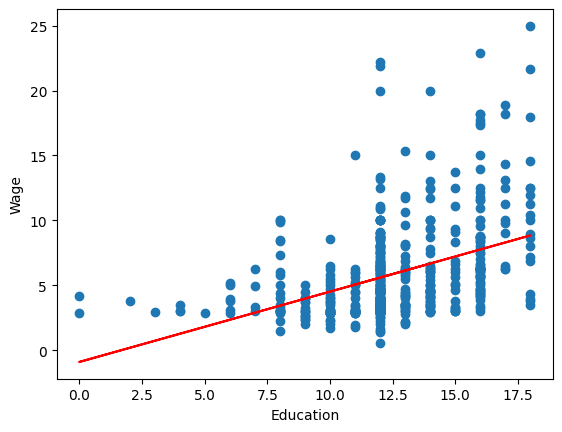

In [30]:
plt.scatter('educ','wage',data=df)
plt.plot(df['educ'],wage_hat,'r')
plt.xlabel('Education')
plt.ylabel('Wage')
plt.show()
pass

#モデルの適合度

モデルの適合度を確認するために次を定義する。
- SST(Total Sum of Squares; 全変動の平方和)
$$SST = \sum_{i=1}^{n} (y_i - \bar{y})^2 = (n - 1) ⋅ \mathrm{Var}(y)$$
- SSE(Explained Sum of Squares; 回帰変動の平方和)
$$SSE = \sum_{i=1}^{n} (\hat{y_i} - \bar{y})^2 = (n - 1) ⋅\mathrm{Var}(̂y)$$
- SSR(Residual Sum of Squares; 残差変動の平方和)
$$SSR = \sum_{i=1}^{n} (\hat{u_i} - 0)^2 = (n - 1)⋅\mathrm{Var}(̂u)$$

ここで, $\mathrm{Var}(z) = \frac{1}{n-1} \sum_{i=1}^{n} (z_i - \bar{z})^2$。これらを使い決定係数と自由度修正後の決定係数を定義する。




- 決定係数
$$R^2 = \frac{SSE}{SST} = 1 - \frac{SSR}{SST}$$
$$R^2 = \frac{Var(̂y)}{Var(y)} = 1 - \frac{Var(̂u)}{Var(y)}$$
- 自由度調整後の決定係数
$$\bar{R^2} = 1 - (1 - R^2) \frac{n-1}{n-k-1}$$

ここで, k = **定数項以外の説明変数の数**(上の例ではk = 1)

ここで説明した変数の値は, 上の例のresの属性として取得できる。

In [31]:
n = res.nobs
k = res.df_model
#n-k-1 = res.df_resid
SST = res.centered_tss
SSE = res.ess
SSR = res.ssr
決定係数 = res.rsquared
修正済み決定係数 = res.rsquared_adj

**決定係数**

上の定義を使うと次のように計算できる。

In [32]:
1-SSR/SST

np.float64(0.1647575109920515)

また次のように計算することも可能。

In [33]:
u_hat = res.resid #残差
wage = df['wage'] #被説明変数
R2 = 1 - np.var(u_hat) / np.var(wage)
R2

0.16475751099205238

しかし「手計算」よりもresの属性.rsquaredを使う方がより簡単。

In [34]:
res.rsquared

np.float64(0.1647575109920515)

**修正済み決定係数**

上の定義を使うと次のように計算できる。

In [35]:
adjR2 = 1-(1-R2)*(n-1)/(n-k-1)
adjR2

0.16316353677638828

一方で修正済み決定係数を取得するメソッドは.rsquared_adjである。

In [36]:
res.rsquared_adj

np.float64(0.1631635367763874)

#賃金の大数化

上の回帰分析では被説明変数wageをそのまま使ったが, 労働経済学では賃金の対数を取り推定するのが一般的である。そのような指揮を賃金方程式とよぶ。その考えにそって, ここではwageの自然対数変換をおこない回帰分析を行う。まず対数化賃金の変数を作成する。

In [37]:
df['wage_log'] = np.log(df['wage'])
formula = 'wage_log ~ educ'
res = smf.ols(formula, data=df).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5838      0.097      5.998      0.000       0.393       0.775
educ           0.0827      0.008     10.935      0.000       0.068       0.098


**＜結果の解釈＞**

resは時式の推定結果である

$$\ln x = \beta_0 + \beta_1{x} + u$$

この式を$x$について微分すると
$$\frac{\ln y}{dx} = \frac{\frac{dy}{y}}{dx} = \frac{yの\%変化}{dx} = \beta1$$
となる。即ち, $\beta_1$は$x$(教育年数)が一単位増加した場合, $y$(賃金)が何%変化するかを示している。この値は教育の収益率である。OLS推定結果は教育年数が1年増えると賃金は約8.3%増加することを示している。

結果を図示する。

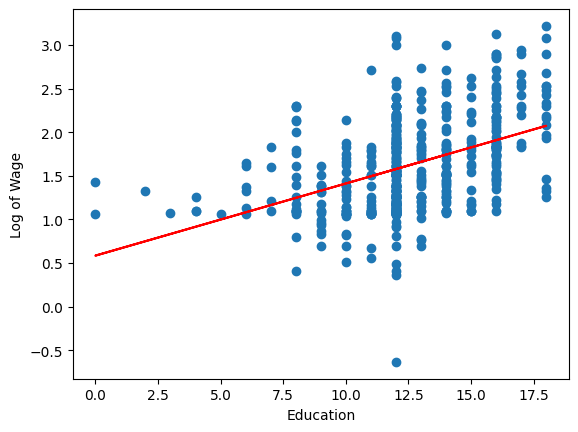

In [38]:
# 予測値の取得
wage_log_hat = res.fittedvalues

# 散布図と回帰曲線
plt.scatter('educ', 'wage_log', data=df)
plt.plot(df['educ'], wage_log_hat, 'r')
plt.xlabel('Education')
plt.ylabel('Log of Wage')
pass

#シミュレーション：OLS推定

上ではデータを使い「手計算」とstatsmodelsを使い計数を計算したが, ここではOLS推定の「意味」をシミュレーションを使って考えてみることにする。

#母集団の考え方

母集団とは分析の対象となる共通の属性などを持つ個人・企業・産業・地域・国などの集合体と言える。ここで重要な点は母集団の大きさとランダム抽出の関係を理解することである。次の二つの例を使って考えてみる。

- 「今年の人間の平均身長」を知りたいとしよう。この場合の母集団は地球上の全ての人間である。しかし，全員の身長を測るのはあまりにも費用が高いため，標本を集め，その平均から「人間の平均身長」を推定することが可能である。この場合「標本の大きさ＜母集団の大きさ」となる。
- 「今年のOECD諸国のGDP」についての何らかの統計量を計算したいとしよう。2021年現在でOECDには38カ国のメンバー国があり，GDPのデータは簡単に入手可能である。これは「標本の大きさ＝母集団の大きさ」という意味なのだろうか。そうだとすれば，標本ではなく母集団全てのデータを扱うことになり，標本の概念である標準誤差などは意味がなくなることになる。しかし「標本の大きさ＜母集団」と解釈できる２つの考え方がある。
  - 1. 時間は「無限」と考えることができる。この考えに従うと、38カ国のGDPデータも「無限」に存在することになる（OECDが存在する限りという意味での「無限」）。従って、ある時点の38カ国のGDPのデータは「無限」の母集団から抽出されたランダム変数と考えることができる。国と時間の概念で考えると母集団の大きさは非常に大きいと解釈できる。
  - 2. 確率変数とは実現可能な数値から１つを実現させる関数である。またGDP自体は確率変数として解釈する方が自然である。従って，38カ国の実現可能なGDPの値が母集団となる。今年度のみでの実現可能なGDPは無数にあるため，この解釈によると「標本の大きさ＜母集団の大きさ」となる。




#プラン
**＜Step 1＞**
- 母集団の大きさは指定しない
- 母集団のデータを生成する回帰式(母集団回帰式)を定義する。
$$Y = \beta_0 + \beta_1X + U$$
  - 説明変数$X$と誤差項$U$はランダム変数であり, 従って$Y$もランダム変数である。
- 母集団から標本を1組抽出し, 標本の大きさを$n$とする。
  - 抽出された値はランダム変数の実現値である。
  $$(y_1, x_1), (y_2, x_2), …, (y_n, x_n)$$
  - 仮定
    - $X$は正規分布に従う$\implies$ $x_1, x_2, …, x_n$は$X$の実現値。
    - $U$は正規分布に従う$\implies$ $u_1, u_2, …, u_n$は$U$の実現値。
    - $X$と$U$は無相関。
    - 実現値$y_1, y_2, …, y_n$は母集団回帰式に従って生成される。

  $$y_i = \beta_0 + \beta_1x_i + u_i, i = 1, 2, …, n$$
  - $\beta_0$と$\beta_1$は未知であり, $u_i$も観測不可能

**＜Step 2＞**
- Step1で抽出した標本を使い回帰分析をおこない, 母集団の回帰式のパラメータを推定する。
  - $\hat{\beta_0}, \hat{\beta_1}$



#シミュレーション

母集団のパラメータを設定する。これはパラメータの真の値であり、この値を推定するのが回帰分析となる。

In [39]:
b0 = 1.0  # 定数項
b1 = 1.0  # 説明変数の係数
su = 1.0  # 誤差項の標準偏差

標本の大きさ

In [40]:
n = 30

標本を抽出するが, 次の無作為なプロセスを通して生成されるとする。

In [41]:
x = norm.rvs(4, 1, size=n)
u = norm.rvs(0, su, size=n)
y = b0 + b1 * x + u

このデータからDataFrameを作成する。()の中の{}は辞書である。

In [42]:
df_sim = pd.DataFrame({'X':x, 'Y':y})

Statsmodelsを使ってOLS推定する。

In [43]:
formula = 'Y ~ X'
res_sim = smf.ols(formula, data=df_sim).fit()

係数の推定値を表示する。

In [44]:
res_sim.params

,0
Intercept,1.352514
X,0.848952


母集団パラメータを比べると, 推定誤差が発生していることがわかる。

#関数化

次に, 上で行ったシミュレーションのコードを関数にまとめることにする。

defを使いmy_simという名前の関数を作成する。
- 引数
  - 標本の大きさ：n
  - 真の定数項：b0 (デフォルトは１)
  - 真のスロープ係数：b1 (デフォルトは１)
  - 誤差項の標準誤差：su (デフォルトは１)
- 戻り値
  - 定数項とスロープ係数の推定値(pandas.Series)
  

In [1]:
def my_sim(n,b0=1,b1=1,su=1):  # nを指定する，　他はデフォルトを設定

    x = norm.rvs(4, 1, size=n)
    u = norm.rvs(0, su, size=n)
    y = b0 + b1 * x + u

    df_sim = pd.DataFrame({'X':x, 'Y':y})

    formula = 'Y ~ X'
    res_sim = smf.ols(formula, data=df_sim).fit()

    return res_sim.params

my_sim()関数の中身は, 上のコードと殆ど変わらない。

標本の大きさを指定して関数を実行してみる。

In [45]:
my_sim(100)

,0
Intercept,0.171970
X,1.180917


シミュレーションで同じ計算を数十万回おこなう場合，１回のシミュレーションに時間がかかり，それをどのように高速化するかが問題になる。その際に役に立つパッケージがNumbaであり，１行のコードを追加するだけで計算を驚く程高速化できる。しかしNumbaには「相性」の問題がある。例えば，上の関数my_sim()で使ったstatsmodels，pandas，scipy.statsはNumbaと相性が悪いが，NumPyは非常に相性が良い。また，Numbaを使う際，リストよりもarrayを使う方が少しでも高速化を図ることができることも覚えておくと良いだろう。以下では，Numbaを使う準備として，NumPyを使う「手計算」関数を考えることにする。

In [46]:
def my_sim_manual(n,b0=1,b1=1,su=1):  # nは標本の大きさ，　他はデフォルトを設定

    x = np.random.normal(loc=4, scale=1, size=n)   # 以下を参照
    u = np.random.normal(loc=0, scale=su, size=n)  # 以下を参照
    y = b0 + b1 * x + u

    var_cov = np.cov(y,x)   # 分散共分散行列
    cov_yx = var_cov[0,1]   # 共分散
    var_y = var_cov[0,0]    # yの分散
    var_x = var_cov[1,1]    # xの分散
    avr_y = y.mean()        # yの平均
    avr_x = x.mean()        # xの平均

    b1hat = cov_yx / var_x  # スロープ係数の推定値
    b0hat = avr_y - b1hat*avr_x  # 定数項の推定値

    return b0hat, b1hat     # 推定値

ここで使ったnp.random.normal()について簡単に説明する。NumPyにはランダム変数を生成するrandomというサブパッケージがあり，その中のnormal()を使う。これはscipy.statsのnorm.rvs()と同じ引数を取り，同じ役割を果たす。

In [47]:
my_sim_manual(100)

(np.float64(0.7988139688422589), np.float64(1.0593163828574348))

my_sim()とmy_sim_manual()の推定値が異なるのはランダム変数（y，x）の値が異なるためであり，それが推定誤差による影響である。

#ループを使ってシミュレーション

標本による推定は誤差が発生する。その誤差はどれだけ大きく(小さく)何に依存するかを確認するためにforループwp使い次のシミュレーションを行うことにする。
- 標本の大きさnのデータをN組用意し（Nは標本数），OLS推定をN回おこなう。
- シミュレーション毎に計算した回帰係数の推定値の分布を図示する。

まずdefを使いシミュレーションの関数を作成するが，パラメータの推定値の計算にはstatsmodelsを使わずに，numpyの関数を使い「手計算」とする。これにより計算を高速化するパッケージNumbaを使うことが可能となる。使い方は簡単でデコレーターと呼ばれる@njit（又は@jit）を関数の上に加えるだけである。これだけで計算速度が数十倍早くなる場合もある。そのために、まず上で使ったmy_sim_manualに@njitを加えて実行する。

In [48]:
@njit
def my_sim_manual(n,b0,b1,su):

    x = np.random.normal(loc=4, scale=1, size=n)
    u = np.random.normal(loc=0, scale=su, size=n)
    y = b0 + b1 * x + u

    var_cov = np.cov(y,x)
    cov_yx = var_cov[0,1]
    var_y = var_cov[0,0]
    var_x = var_cov[1,1]
    avr_y = y.mean()
    avr_x = x.mean()

    b1hat = cov_yx / var_x
    b0hat = avr_y - b1hat*avr_x

    return b0hat, b1hat

このmy_sim_manual()の内容は，上で作成したmy_sim_manual()と全く同じである。単に@njitの一行だけが付け加えられているだけだが，これにより全く別の高速化された関数に「変身」することになる。

次にmy_sim_manual()をforループで計算するシミュレーション用の関数を用意する。

In [49]:
@njit
def my_sim_loop(n,N,b0=1.0,b1=1.0,su=1.0):  # nとN以外はデフォルトを指定

    b0hat_arr = np.zeros(N)  # OLS推定量を入れるarray（0がN個並んでいる）
    b1hat_arr = np.zeros(N)  # OLS推定量を入れるarray（0がN個並んでいる）

    for i in range(N):  # N 回のループ

        # 返り値が２つあるので、割り当てる場合には左辺の変数を ',' で区切る
        b0hat, b1hat = my_sim_manual(n,b0=b0,b1=b1,su=su)

        b0hat_arr[i] = b0hat  # i番目に定数項の推定値をarrに追加
        b1hat_arr[i] = b1hat  # i番目にスロープ係数の推定値をarrに追加

    return b0hat_arr, b1hat_arr  # N回ループ終了後にarrayをタプルとして返すオブジェクト

標本の大きさを50,シミュレーションの回数を100_00としてシミュレーションを始める。

In [50]:
b0hat, b1hat = my_sim_loop(n=50,N=100_000)

$\hat{\beta_0}$の分布を図示する。

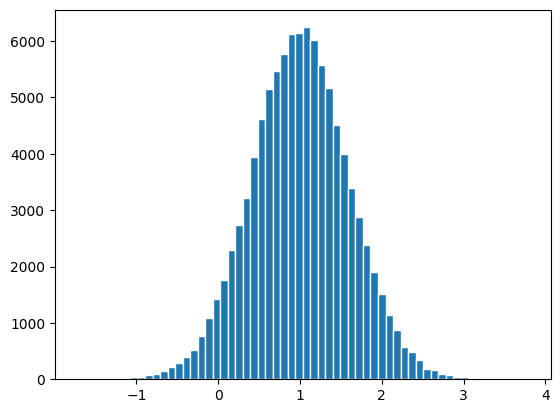

In [51]:
plt.hist(b0hat,bins=60, edgecolor='white')
pass

$\hat{\beta_1}$の分布を図示する・

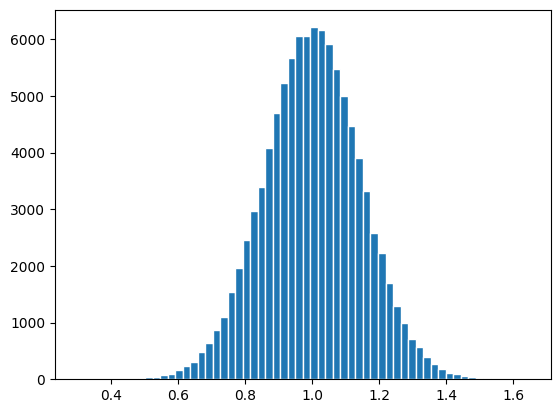

In [52]:
plt.hist(b1hat,bins=60, edgecolor='white')
pass

yの理論値を図示するが, 図示の時間短縮のためN回のシミュレーション中の最初のr回の回帰線だけ表示する。

In [53]:
r = 1000

r回の回帰線をforループを使って重ねて図示してみる。

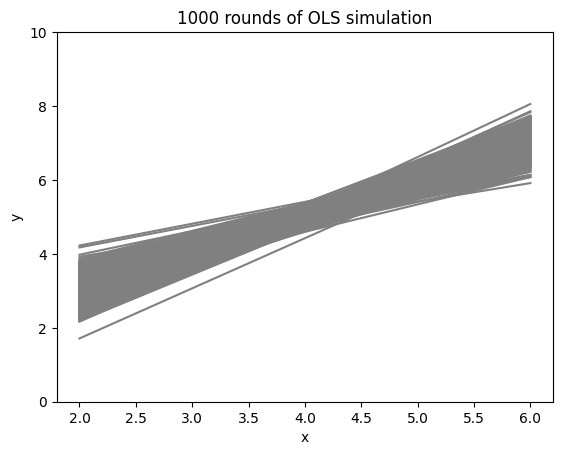

In [54]:
xx = np.linspace(2,6,50)

for i in range(r):  # r回のループで図示
    yhat = b0hat[i] + b1hat[i]*xx  # yの予測値
    plt.plot(xx, yhat, 'grey')  # yの予測値を図示

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0,10) # 縦軸の表示範囲を設定
plt.title(f'{r} rounds of OLS simulation')
pass

**＜シミュレーションの含意＞**

まず上の２つのヒストグラムを見ると, 値にばらつきがある。これは推定値($\hat{\beta_0}$と$\hat{\beta_1}$)が確率変数であるためである。その実現値は, 真の値($\beta_0 = 1.0$と$\beta_1 = 1.0$)を中心に左右対称に分布している。即ち, 推定値は不偏性を満たしている。次の章で簡単に説明するが, 上で行ったシミュレーションは不偏推定量に必要な仮定を満たしているためである。

これを踏まえて, 回帰直線の図を考えよう。同じ回帰式を使いn回のシミュレーションを行った後, 最初のr個の回帰直線を重ねて描いているためパイプのような形になっている。一方で, 実際の実証分析ではこのような繰り返しの試行は不可能であり多くの場合は一度だけである。言い換えると, 実証研究ではn個の回帰直線の中から１つだけを結果として「ランダムに選んでいる」のと等しい。この意味をさらに考えるために, パイプの幅が広ければ広いほど, 二つの回帰直線の位置は大きく異なる可能性が高くなり, 精度が低い結果になる。逆に, パイプの幅が狭ければ狭いほど, ２つの結果は似たものになり, より正確な推定結果となる。このように実証分析ではパイプの幅が可能な限り小さくなる工夫が必要になる。その一つが標本の大きさnである。nが増えるとパイプは細くなり, 極限n→∞(即ち, 標本の大きさと母集団の大きさの差が限りなく０に近づく)ではパイプの形が直線(母集団回帰式)に近づくことになる。このように, 実証分析において標本の大きさは非常に重要な役割を果たすことになる。